<a href="https://colab.research.google.com/github/IdoRoss/Deep-Learning-In-Computer-Vision-Middle-Exercise/blob/main/CV_Middle_exe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Computer Vision Course Middle Assignment</h1>

# Importing libraries ,mounting drive And Function Definitions

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from timeit import default_timer as timer
import os
import random
import glob
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/Computer Vision Course/Middle exe")

Mounted at /content/drive


**Note:** for this exercise we took 1000 random pictures out of each class from the training set (locally) and placed them into a validation set

### Confusion Matrix Function Definition

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Accuracy Calculation Function Definition

In [ ]:
def calc_accuracy(y_true, y_pred):
  correct = 0
  for i in range(len(y_true)):
    if y_true[i] == y_pred[i]:
      correct += 1
  return (correct/len(y_true))

# Model Number 1

## Data Preprocessing

We choose 10000 epochs because later on we will use "Early Stopping".

In [ ]:
train_path = "dataset/dataset/training_set"
valid_path = "dataset/dataset/valid_set"
test_path = "dataset/dataset/test_set"
epochs = 10000
batch_size = 12
target_size = (32,32)
input_shape = (32,32,3)
classes = ["airplane","bird","frog"]

We choose to normalize  the pixels between 0 and 1 as a preprocessing method.
For data augmentations we choose horizontal flip, rotating the image between 0 and 10 degrees and zooming the image between 0 and 0.15 percent.

In [ ]:
train_batchs = ImageDataGenerator(rescale = 1./255,horizontal_flip=True,rotation_range=10,zoom_range=0.15).flow_from_directory(directory=train_path,target_size=target_size, classes=classes,batch_size=batch_size, shuffle=True)
valid_batchs = ImageDataGenerator(rescale = 1./255).flow_from_directory(directory=valid_path,target_size=target_size, classes=classes,batch_size=batch_size, shuffle=False)
test_batchs = ImageDataGenerator(rescale = 1./255).flow_from_directory(directory=test_path,target_size=target_size, classes=classes,batch_size=batch_size, shuffle=False)


Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


## Building The First CNN Model

For our first model we choose the following architecture: 
We choose the "relu" activation func to avoid the "Vanishing gradient" issue that comes with sigmoid, we choose (3,3) filter sizes as they lead to less parameters and more layeres and therefore more nonlinearity, than a bigger filter size for the same receptive field.

In [ ]:
model = Sequential([
                    Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu", input_shape=input_shape),
                    MaxPool2D(pool_size=(2,2),strides=2),
                    Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu"),
                    MaxPool2D(pool_size=(2,2),strides=2),
                    Conv2D(filters=128,kernel_size=(3,3),padding="same",activation="relu"),
                    MaxPool2D(pool_size=(2,2),strides=2),
                    Flatten(),
                    Dense(units=128,activation="relu"),
                    Dense(units=64,activation="relu"),
                    Dense(units=len(classes),activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

## Training The First CNN Model

To train the first model we enabled the use of GPU as the hardware accelerator, we choose the adam optimizer, the loss function we used is categorical crossentropy for a multiclass CNN. We also used the "Early Stopping" callback to try and avoid overfitting, we choose to monitor the loss of the validation set and have the model stop training if the loss of the validation set wont improve after 3 epochs, the model will restore the best weights.

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"])
time = timer()
history = model.fit(x= train_batchs, epochs=epochs, validation_data=valid_batchs,callbacks=[EarlyStopping(monitor="val_loss", patience = 3, restore_best_weights=True)] , verbose=1)
total_time = round((timer() - time)/60)
print(f"Finished training after {total_time} minutes")

Epoch 1/10000
1000/1000 [==============================] - 2033s 2s/step - loss: 0.7464 - accuracy: 0.6699 - val_loss: 0.5739 - val_accuracy: 0.7647
Epoch 2/10000
1000/1000 [==============================] - 47s 47ms/step - loss: 0.5507 - accuracy: 0.7794 - val_loss: 0.5282 - val_accuracy: 0.7863
Epoch 3/10000
1000/1000 [==============================] - 48s 48ms/step - loss: 0.4930 - accuracy: 0.7987 - val_loss: 0.4581 - val_accuracy: 0.8133
Epoch 4/10000
1000/1000 [==============================] - 48s 48ms/step - loss: 0.4425 - accuracy: 0.8235 - val_loss: 0.3818 - val_accuracy: 0.8540
Epoch 5/10000
1000/1000 [==============================] - 48s 48ms/step - loss: 0.4105 - accuracy: 0.8357 - val_loss: 0.3999 - val_accuracy: 0.8550
Epoch 6/10000
1000/1000 [==============================] - 48s 48ms/step - loss: 0.3827 - accuracy: 0.8458 - val_loss: 0.3679 - val_accuracy: 0.8587
Epoch 7/10000
1000/1000 [==============================] - 47s 47ms/step - loss: 0.3640 - accuracy: 0.8538

## Evaluating The First CNN Model

### The Train Process

Visualizing the loss. We can see the the model tended to overfitting after epoch number 9. So to prevent that, early stopping stopped the model from over fitting.

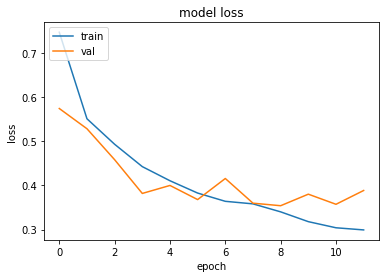

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Visualizing the Accuracy.

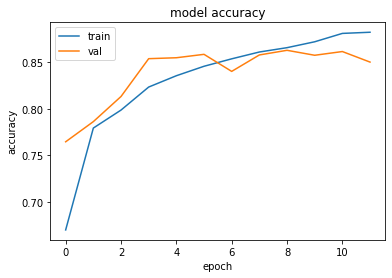

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
train_accuracy = round(history.history['accuracy'][-4], 2)
valid_accuracy = round(history.history['val_accuracy'][-4], 2)
print(f'The model accuracy on train data is: {train_accuracy}')
print(f'The model accuracy on validation data is: {valid_accuracy}')

The model accuracy on train data is: 0.87
The model accuracy on validation data is: 0.86


### Evaluating On The Test Set

Plotting the confusion matrix on the separate test data to visualize the model performance on each of the classes.

Confusion matrix, without normalization
[[953  23  24]
 [117 715 168]
 [ 22  32 946]]


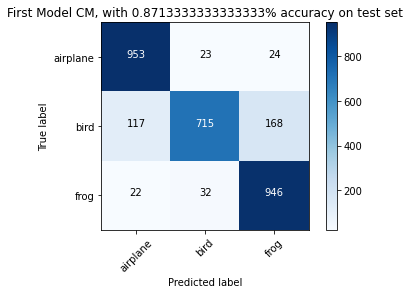

In [ ]:
predictions = model.predict(x=test_batchs, verbose=0)
cm = confusion_matrix(y_true=test_batchs.classes, y_pred=np.argmax(predictions, axis=-1))
acc = calc_accuracy(test_batchs.classes,np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm=cm, classes=classes, title=f"First Model CM, with {acc}% accuracy on test set",normalize=False)

# Model Number 2

## Data Preprocessing

for the second model we choose the "Transfer Learning" method. We choose the use the vgg16 model trained on "Imagenet" dataset as it learned to differentiate between meny classes including simular classes to our classes.
Because the vgg16 model was build to classify images that are 224x224x3 we needed to reshape our images to fit that size (done by the "ImageDataGenerator"), we also needed to use the vgg16 preprocess method as this is the preprocess the model was trained on.

In [ ]:
train_path = "dataset/dataset/training_set"
valid_path = "dataset/dataset/valid_set"
test_path = "dataset/dataset/test_set"
epochs = 10000
batch_size = 12
target_size = (224, 224)
input_shape = (224, 224, 3)
classes = ["airplane","bird","frog"]

In [ ]:
train_batchs = ImageDataGenerator(preprocessing_function= keras.applications.vgg16.preprocess_input,horizontal_flip=True,rotation_range=10,zoom_range=0.15).flow_from_directory(directory=train_path,target_size=target_size, classes=classes,batch_size=batch_size, shuffle=True)
valid_batchs = test_batchs = ImageDataGenerator(preprocessing_function= keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path,target_size=target_size, classes=classes,batch_size=batch_size, shuffle=False)
test_batchs = ImageDataGenerator(preprocessing_function= keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path,target_size=target_size, classes=classes,batch_size=batch_size, shuffle=False)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


## Building The Second CNN Model

For the second model we used vgg's layers but choose to use vgg's weights up to the  last 3 Convolution layers, add our own Fully Connected layers and train only those.

In [ ]:
vgg16 = VGG16(include_top=False, weights="imagenet", input_shape=input_shape)
model2 = Sequential()

for layer in vgg16.layers[:-4]:
  model2.add(layer)

for layer in model2.layers:
  layer.trainable = False

model2.add(Conv2D(filters=512,kernel_size=(3,3),padding="same",activation="relu"))
model2.add(Conv2D(filters=512,kernel_size=(3,3),padding="same",activation="relu"))
model2.add(Conv2D(filters=512,kernel_size=(3,3),padding="same",activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=2))
model2.add(Flatten())
model2.add(Dense(units=256,activation="relu"))
model2.add(Dense(units=128,activation="relu"))
model2.add(Dense(units=len(classes),activation="softmax"))
                   
model2.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                         

## Training The Second CNN Model

Training the second model similarly to the first one.

In [ ]:
model2.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"])
time = timer()
history2 = model2.fit(x= train_batchs, epochs=epochs, validation_data=valid_batchs,callbacks=[EarlyStopping(monitor="val_loss", patience = 3, restore_best_weights=True)] , verbose=1)
total_time = round((timer() - time)/60)
print(f"Finished training after {total_time} minutes")

Epoch 1/10000
1000/1000 [==============================] - 3963s 4s/step - loss: 4.0572 - accuracy: 0.6821 - val_loss: 0.7081 - val_accuracy: 0.7333
Epoch 2/10000
1000/1000 [==============================] - 243s 243ms/step - loss: 0.5622 - accuracy: 0.7778 - val_loss: 0.4843 - val_accuracy: 0.8127
Epoch 3/10000
1000/1000 [==============================] - 242s 242ms/step - loss: 0.5099 - accuracy: 0.8009 - val_loss: 0.4933 - val_accuracy: 0.8270
Epoch 4/10000
1000/1000 [==============================] - 242s 242ms/step - loss: 0.4900 - accuracy: 0.8111 - val_loss: 0.6955 - val_accuracy: 0.7263
Epoch 5/10000
1000/1000 [==============================] - 242s 242ms/step - loss: 0.4906 - accuracy: 0.8118 - val_loss: 0.6188 - val_accuracy: 0.8030
Finished training after 82 minutes


## Evaluating The Second CNN Model

### The Train Process

Visualizing the loss. We can see the the model tended to overfitting after epoch number <h1>number</h1>. so to prevent that, early stopping stopped the model from over fitting.

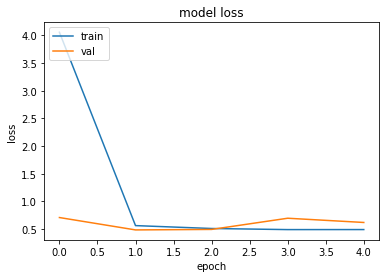

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Visualizing the Accuracy.

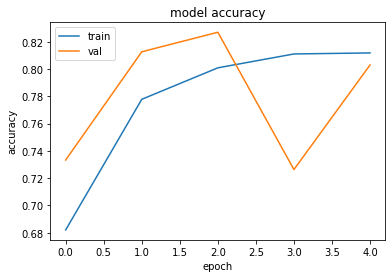

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
train_accuracy = round(history2.history['accuracy'][-4], 2)
print(f'The model accuracy on train data is: {train_accuracy}')
valid_accuracy = round(history2.history['val_accuracy'][-4], 2)
print(f'The model accuracy on validation data is: {valid_accuracy}')

The model accuracy on train data is: 0.78
The model accuracy on validation data is: 0.81


### Evaluating On The Test Set

Plotting the confusion matrix on the separate test data to visualize the model performance on each of the classes.

Confusion matrix, without normalization
[[934  46  20]
 [180 665 155]
 [ 22 106 872]]


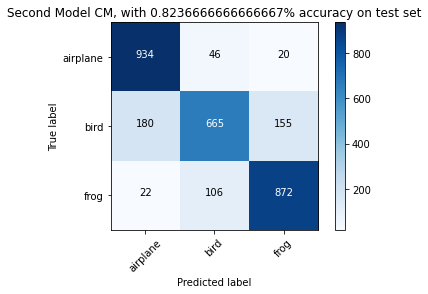

In [ ]:
predictions2 = model2.predict(x=test_batchs, verbose=0)
cm = confusion_matrix(y_true=test_batchs.classes, y_pred=np.argmax(predictions2, axis=-1))
acc = calc_accuracy(test_batchs.classes,np.argmax(predictions2, axis=-1))
plot_confusion_matrix(cm=cm, classes=classes, title=f"Second Model CM, with {acc}% accuracy on test set",normalize=False)

# Conclusions

The First model has preformed better then the second one on the test set.
The First model also used less parameters 363,971 compered to the second model's 21,170,755 parameters.
Therefore the "winning" model is the first one.